© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [32]:
import os
import re

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from tqdm import tqdm

from representation_similarity_utilities import compare_activations

# font import
import matplotlib.font_manager as fm
# Add every font at the specified location
font_dir = [os.path.join('..', '..', 'Work_Sans', 'static')]
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

sns.set(style='white', context="poster", font='Work Sans Regural')

In [33]:
dataset = 'MIMIC'
models = [
    # os.path.join('SimCLR', dataset, '20230329-112506_l1_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.75.hdf5'),
    # os.path.join('SimCLR', dataset, '20230403-115302_200_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120645_e100_esFalse_bs128_wTrue_f2_fl', 'simclr.frozen.0.75.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-120904_e100_esFalse_bs128_wTrue_f1_m', 'simclr.frozen.0.76.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121322_e100_esFalse_bs128_wTrue_f0', 'simclr.frozen.0.77.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-121747_e100_esFalse_bs128_wTrue_f1', 'simclr.frozen.0.79.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122120_e100_esFalse_bs128_wTrue_f2', 'simclr.frozen.0.69.hdf5'),
    os.path.join('SimCLR', dataset, '20230403-122444_e100_esFalse_bs128_wTrue_f3', 'simclr.frozen.0.78.hdf5'),
    os.path.join('Supervised', dataset, '20230403-133103_l2_e100_esFalse_bs128_wTrue', 'supervised.finetuned.0.81.hdf5')
]
intermediate_layer = 7  # last CNN layer

In [34]:
model_file_name = models[1]
model_name = '1m'
# test = (np.load(os.path.join('SimCLR', dataset, 'test_x.npy')),
#            np.load(os.path.join('SimCLR', dataset, 'test_y.npy')))

In [35]:
test_listfile = pd.read_csv(os.path.join('..', '..', 'datasets', dataset, 'test_listfile.csv'))
subjects = pd.read_csv(os.path.join('..', '..',  'datasets', dataset, 'demographics_rich.csv'))
# extract subject_id from stay
regex = r"(?:^\d+)"
test_listfile.loc[:, "SUBJECT_ID"] = test_listfile.stay.apply(lambda stay: re.search(regex, stay).group(0))
test_listfile.SUBJECT_ID = test_listfile.SUBJECT_ID.astype(int)
test_listfile.drop(['stay'], axis=1, inplace=True)
test_listfile = test_listfile.merge(subjects, how='left', on='SUBJECT_ID')
test_listfile.head()

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0


In [36]:
pretrained_model = tf.keras.models.load_model(model_file_name, compile=False)  # compile=False as we use the model only for inference
pretrained_model.summary()

Model: "TPN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96)             0       

In [37]:
# Load preprocessed data
np_train = (np.load(os.path.join('SimCLR', dataset, 'train_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'train_y.npy')))
np_val = (np.load(os.path.join('SimCLR', dataset, 'val_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'val_y.npy')))
np_test = (np.load(os.path.join('SimCLR', dataset, 'test_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'test_y.npy')))

probs = pretrained_model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
# print(simclr_utitlities.evaluate_model_simple(pretrained_model.predict(np_test[0]), np_test[1], return_dict=True))

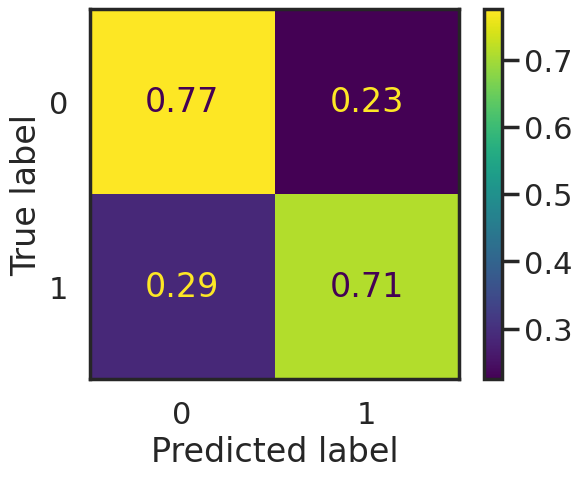

In [38]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][:, 1], predictions, normalize='true')
ConfusionMatrixDisplay(cm).plot()

In [39]:
male_rows = test_listfile.index[test_listfile["GENDER"] == "M"].tolist()
female_rows = test_listfile.index[test_listfile["GENDER"] == "F"].tolist()
print("Male rows: {} and Female rows: {}".format(len(male_rows), len(female_rows)))

Male rows: 1797 and Female rows: 1439


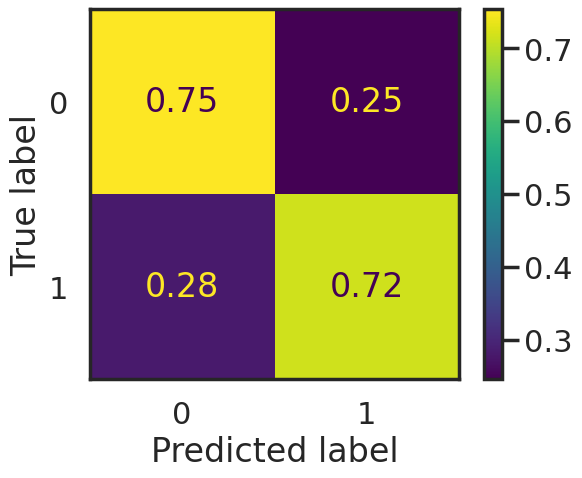

In [40]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows, 1], predictions[female_rows], normalize='true')
ConfusionMatrixDisplay(cm).plot()

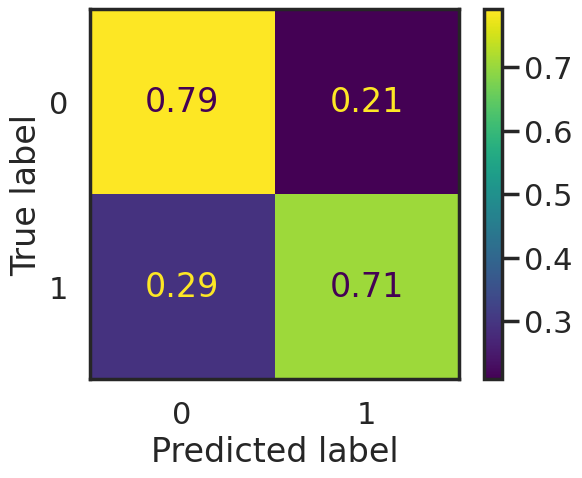

In [41]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][male_rows, 1], predictions[male_rows], normalize='true')
ConfusionMatrixDisplay(cm).plot()

## Intersectional Gender-Age

In [42]:
test_listfile

,y_true,SUBJECT_ID,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,GENDER,AGE
0,1,10011,NaN,Private,CATHOLIC,UNKNOWN/NOT SPECIFIED,F,1
1,0,10026,NaN,Medicare,OTHER,WHITE,F,0
2,0,10030,NaN,Medicare,CATHOLIC,WHITE,M,0
3,0,10042,NaN,Medicare,UNOBTAINABLE,WHITE,M,0
4,0,10094,NaN,Medicare,UNOBTAINABLE,BLACK/AFRICAN AMERICAN,M,0
...,...,...,...,...,...,...,...,...
3231,0,9970,NaN,Medicaid,CATHOLIC,WHITE,M,1
3232,0,9977,NaN,Medicare,PROTESTANT QUAKER,WHITE,M,0
3233,0,99863,PORT,Government,NOT SPECIFIED,WHITE - BRAZILIAN,M,1
3234,0,99883,ENGL,Medicare,PROTESTANT QUAKER,WHITE,M,0


In [43]:
female_rows_less65 = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 1)].tolist()
female_rows_gr65 = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 0)].tolist()
print("Female <65 rows: {} and Female >=65 rows: {}".format(len(female_rows_less65), len(female_rows_gr65)))

Female <65 rows: 568 and Female >=65 rows: 871


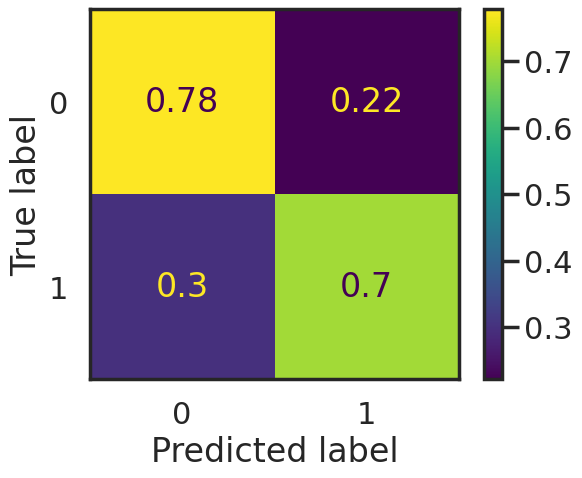

In [44]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_less65, 1], predictions[female_rows_less65], normalize='true')
ConfusionMatrixDisplay(cm).plot()

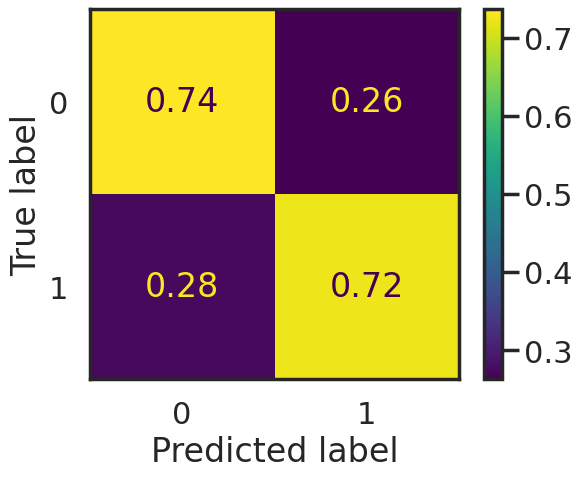

In [45]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_gr65, 1], predictions[female_rows_gr65], normalize='true')
ConfusionMatrixDisplay(cm).plot()

## Intersectional Gender-Age-Insurance

In [46]:
female_rows_less65_private = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 1) & (test_listfile["INSURANCE"] == "Private")].tolist()
female_rows_less65_medicaid = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 1) & (test_listfile["INSURANCE"] == "Medicaid")].tolist()
female_rows_gr65_private = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 0) & (test_listfile["INSURANCE"] == "Private")].tolist()
female_rows_gr65_medicaid = test_listfile.index[(test_listfile["GENDER"] == "F") & (test_listfile["AGE"] == 0) & (test_listfile["INSURANCE"] == "Medicaid")].tolist()
print("Female <65 rows (private-medicaid): {}-{}  and Female >=65 rows (private-medicaid): {}-{}".format(len(female_rows_less65_private), len(female_rows_less65_medicaid), len(female_rows_gr65_private), len(female_rows_gr65_medicaid)))

Female <65 rows (private-medicaid): 324-84  and Female >=65 rows (private-medicaid): 61-10


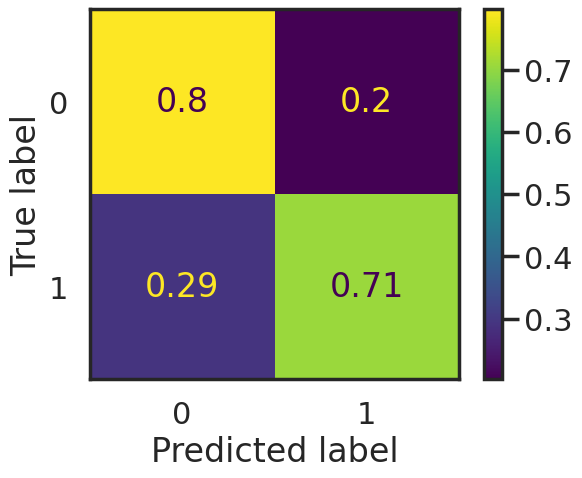

In [47]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_less65_private, 1], predictions[female_rows_less65_private], normalize='true')
ConfusionMatrixDisplay(cm).plot()

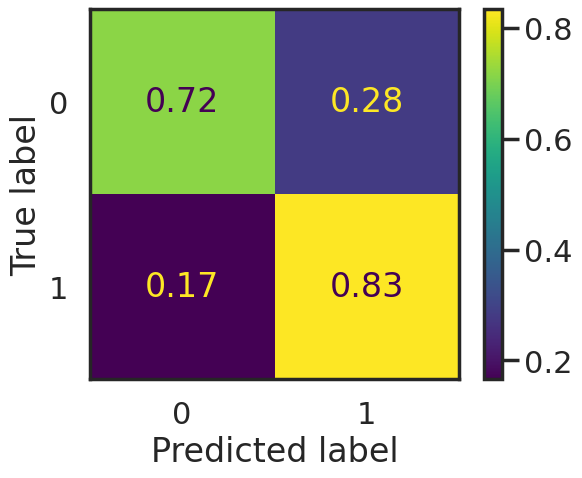

In [48]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_less65_medicaid, 1], predictions[female_rows_less65_medicaid], normalize='true')
ConfusionMatrixDisplay(cm).plot()

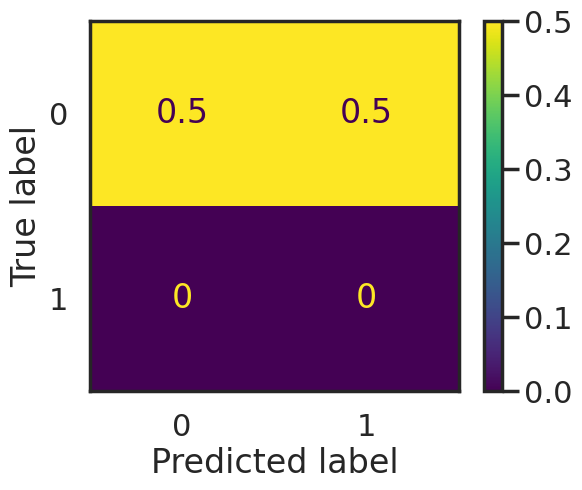

In [49]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_gr65_medicaid, 1], predictions[female_rows_gr65_medicaid], normalize='true')
ConfusionMatrixDisplay(cm).plot()

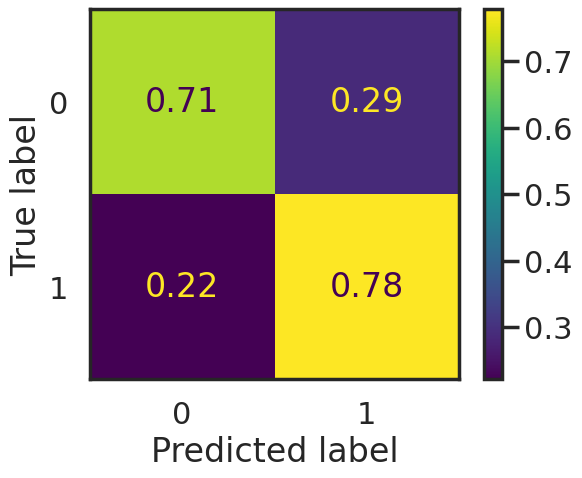

In [50]:
# cm = confusion_matrix(np_test[1][:, 1], predictions , normalize='pred')
cm = confusion_matrix(np_test[1][female_rows_gr65_private, 1], predictions[female_rows_gr65_private], normalize='true')
ConfusionMatrixDisplay(cm).plot()